# Similar Locations App
## IBM Data Science Capstone Project
### August 2020

## Executive Summary

The proposed software will have the following main functionality. Provided an input location and a destination, it will investigate various characteristics of the input location, and suggest the most similar locations within a predetermined area of the destination.

This functionality is expected to address the following two use cases:

* Suppose a user would like to move from his/her current location to a new city, perhaps due to professional reasons, climate change or religious beliefs. It is difficult to find an area that has similar characteristics to the location the user is moving away from, and this software could help

* Suppose a user has a “dream” location in mind and would like to see if something similar is available closer to his/her current location.



In [1]:
'''
Install external dependencies
'''

!pip install folium

     |████████████████████████████████| 102kB 7.1MB/s ta 0:00:011


In [2]:
'''
Import dependencies
'''
import requests
import random 
import re
import folium
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt 
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 

In [48]:
class SimilarLocations(object):
    '''
    This class stores user input data on the location/origin coordinates and the destination/area of interest coordinates
    
    It then gets venues data using the Foursquare API, parses and processes this information and performs hierarchical clustering
    between the location/origin area and a 5x5 grid of areas (each 2x2km in size) centred on the destination coordinates
    
    The main output is a map highlighting the area that is most similar to to location/origin area.
    
    Optionally, the venues data can be printed, and the hierarchy dendrogram can be displayed
    '''
    
    
    def __init__(self, location_latitude, location_longitude, destination_latitude, destination_longitude):
        '''
        Initialise the instance with the input parameters
        '''
        
        self.location_coordinates = (location_latitude, location_longitude)
        self.destination_coordinates = (destination_latitude, destination_longitude)
        self.radius = 1000
        self.location_data = None
        self.destination_data = None
        self.merged_data = None
        self.venues = None
        self.best_hit = None
        self.Z = None
        self.indices = {}
        self.client_id = 'TG40BRCQYER2OYURQDLLHRAZXRKCNEUN0OJ3GDNBQRN1UKKU'
        self.client_key = '1VGE2OEITVYRATNSCKEJN1E220BMNGBRW5XL35Q4EDAXDCIP'
        self.api_version = '20200201'
        self.api_limit = 100
        self.base_url = 'https://api.foursquare.com/v2/venues'
        
        
    def render_map(self):
        '''
        Renders a map using the folium package
        
        @param data - A data frame with 'Label', 'Latitude' and 'Longitude' values
        
        @returns A folium.Map object
        '''
        latitude = self.destination_coordinates[0]
        longitude = self.destination_coordinates[1]
        data = self.look_up_area(self.best_hit)
        new_map = folium.Map(location=[latitude, longitude], zoom_start=11)
        
        
        for lat, lng, area in zip(data['Latitude'], data['Longitude'], data['Location']):
            label = '{}'.format(area)
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=1,
                parse_html=False).add_to(new_map)
        
        return new_map
    
    
    def run(self):
        '''
        Run the process to get the area from a grid centred around the
        coordinates provided by the users as "destination" which is most 
        similar to the coorindates provided by the users as "location"
        
        The similarity is based on the hierarchical clustering of multidimensional
        data on venues available within a given range to the coordinates
        '''
    
        self.create_dataframes()
        
        self.merged_data = self.destination_data.append(self.location_data)
        
        self.venues = self.get_nearby_venues(self.merged_data['Location'], 
                               self.merged_data['Latitude'], 
                               self.merged_data['Longitude'])
        
        self.best_hit = self.get_most_similar()

        
    def create_dataframes(self):
        '''
        Create the data frames for the location/origin area and the destination grid
        '''
        # Create data frame for location
        initial_location_data = {'Location': ['location'], 'Latitude': [self.location_coordinates[0]], 'Longitude': [self.location_coordinates[1]]}
        self.location_data = pd.DataFrame(data = initial_location_data)

        # Create data frame for destination
        self.destination_data = self.create_destination_grid()
        
    
    def create_destination_grid(self):
        '''
        Creates a grid of areas centred around an initial destination coordinates.
        The grid is 5x5, with cells that are sized 2x2 km
        
        Notes: 
        - 1 degree of latitude is 111.32 km
        - 1 degree of longitude is 40075 km * cos (latitude) / 360
        
        @returns An array of labels and latitude & longitude coordinates
        '''
        
        count = 0
        labels = []
        latitudes = []
        longitudes = []
        
        # Create latitude and logitude values centred around the user input
        for i in range(-2, 3):
            if i == 0:
                latitude = self.destination_coordinates[0]
            else:
                latitude = self.destination_coordinates[0] + i * 0.008983 * 2
            for j in range(-2, 3):
                count += 1
                if j == 0:
                    longitude = self.destination_coordinates[1]
                else:
                    step = 1 / ((40075 * math.cos(latitude)) / 360)
                    longitude = self.destination_coordinates[1] + j * step * 2
                latitudes.append(latitude)
                longitudes.append(longitude)
                labels.append("destination_area_%i" % count)
        
        # Save the data in a data frame
        grid = pd.DataFrame(data = {'Location': labels, 
                                    'Latitude': latitudes, 
                                    'Longitude': longitudes})
        return(grid)
    
    
    def get_nearby_venues(self, areas, latitudes, longitudes):
        '''
        Gets the data for venues centred around a set of coordinates.
        The returned data is stored in a data frame and various transformations happen 
        on this data frame (merging, encoding, updating and summing up)
        
        @param areas - An array of labels
        @param latitudes - An array of latitude coordinates (decimal degrees)
        @param longitudes - An array of latitude coordinates (decimal degrees)
        
        @return A data frame
        '''
    
        venues_list=[]
        for area, lat, lng in zip(areas, latitudes, longitudes):
            # create the API request URL
            url = self.base_url + '/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                self.client_id, 
                self.client_key, 
                self.api_version, 
                lat, 
                lng, 
                self.radius, 
                self.api_limit)

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                area, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['location']['distance'], 
                v['venue']['categories'][0]['name'],
                v['venue']['categories'][0]['id'],
            ) for v in results])

            # print(f"{len(results)} venues within {self.radius} m of {area} center")

        # Create and label data frame of venues
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = [
            'Location', 
            'Location Latitude', 
            'Location Longitude', 
            'Venue Name', 
            'Venue Latitude', 
            'Venue Longitude', 
            'Venue Distance to Location Centre', 
            'Venue Category',
            'Venue Category ID',
        ]

        # Group the venues by 'Location'
        nearby_venues.groupby('Location')
        # Encode the 'Venue Category' items into binary (0/1)
        encoded_venues = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")
        # Add the 'Location' column to the encoded data frame
        encoded_venues['Location'] = nearby_venues['Location']
        # Sum up the venues counts
        summed_venues = encoded_venues.groupby('Location').sum()
        
        return(summed_venues)
    
    def get_most_similar(self):
        '''
        Perform hierarchical clustering of the venues data
        
        @return - If there is a best hit, return the name of this area, oterwise None
        '''
        dist_matrix = distance_matrix(self.venues, self.venues)
        self.Z = hierarchy.linkage(dist_matrix, 'complete')
        
        last_item = self.venues.shape[0] - 1
        self.indices['start_index'] = last_item
        best_match = None
        
        for i in range(len(self.Z)):
            if self.Z[i][0] == last_item:
                best_match = self.Z[i][1]
            elif self.Z[i][1] == last_item:
                best_match = self.Z[i][0]
        if best_match:
            self.indices['end_index'] = int(best_match)
            return self.venues.iloc[int(best_match)].name
        
        
    def look_up_area(self, name):
        '''
        Look up the row in the 'merged_data' data frame based on an area name
        
        @param name - String, the label of an area
        
        @returns The location of the corresponding row
        '''
        return self.merged_data.loc[self.merged_data['Location'] == name]
    
    
    def render_dendrogram(self):
        '''
        Render a dendrogram of the areas from 'venues'
        '''
        
        dendro = hierarchy.dendrogram(self.Z)
        
    def get_location_and_best_hit_venues(self):
        '''
        Get the venues of the input location and of the best match
        
        @returns A data frame
        '''
        
        combined = pd.DataFrame(self.venues.iloc[self.indices['start_index']])
        combined = combined.join(pd.DataFrame(self.venues.iloc[self.indices['end_index']]))
        
        return combined
        
        

In [49]:
sl = SimilarLocations(location_latitude=43.704689, location_longitude=-79.403590, destination_latitude=52.1988895, destination_longitude=0.0849678)
sl.run()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:215: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


In [30]:
# Render a map of the destination
sl.render_map()

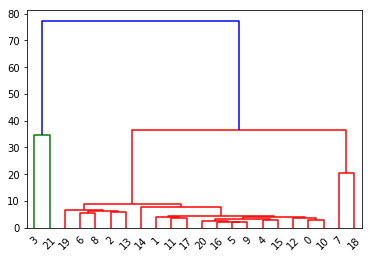

In [31]:
# Display the dendrogram
sl.render_dendrogram()

In [50]:
sl.get_location_and_best_hit_venues()

,location,destination_area_12
African Restaurant,0,2
Airport,0,0
Airport Lounge,0,0
Airport Terminal,0,0
Arts & Crafts Store,1,0
Asian Restaurant,0,1
Athletics & Sports,0,0
Auto Garage,0,0
BBQ Joint,0,1
Bakery,3,2
